In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import dataset_preprocessing as dp

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D,Convolution2D
from tensorflow.keras.utils import plot_model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras.layers import SeparableConv2D
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from keras.layers import GlobalAveragePooling2D
from keras import layers
from livelossplot.inputs.tf_keras import PlotLossesCallback
from keras.regularizers import l2

from IPython.display import SVG, Image
%matplotlib inline

In [2]:
#Defining of parameters
l2_regularization=0.01
batch_size = 32
num_epochs = 150
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 50
path = 'Prelu/models/'
l2_regularization=0.01
height = 48
width = 48

X_train,train_y,X_test,test_y = dp.train_test_split()

In [3]:
def create_model():
    # model parameters
    regularization = l2(l2_regularization)    
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = keras.layers.advanced_activations.PReLU(alpha_initializer='normal', weights=None)(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = keras.layers.advanced_activations.PReLU(alpha_initializer='normal', weights=None)(x)

    residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = keras.layers.advanced_activations.PReLU(alpha_initializer='normal', weights=None)(x)
    x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = keras.layers.advanced_activations.PReLU(alpha_initializer='normal', weights=None)(x)
    x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = keras.layers.advanced_activations.PReLU(alpha_initializer='normal', weights=None)(x)
    x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)
    x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = keras.layers.advanced_activations.PReLU(alpha_initializer='normal', weights=None)(x)
    x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])
    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy',dp.f1_score,dp.precision_m, dp.recall_m])
#     model.summary()
    return model

In [4]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 46, 46, 8)    16928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
data_generator = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False,  
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    horizontal_flip=True,
    vertical_flip=False) 

In [6]:
#callback
log_path = path + 'prelu.log'
csv_logger = CSVLogger(log_path, append=False)
early_stop = EarlyStopping('val_loss', patience=50)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(50/2.5), verbose=1)
models_path_trained = path + '_prelu_trained_model'
model_names = models_path_trained + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint_model = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [PlotLossesCallback(),checkpoint_model, csv_logger, early_stop, reduce_lr]

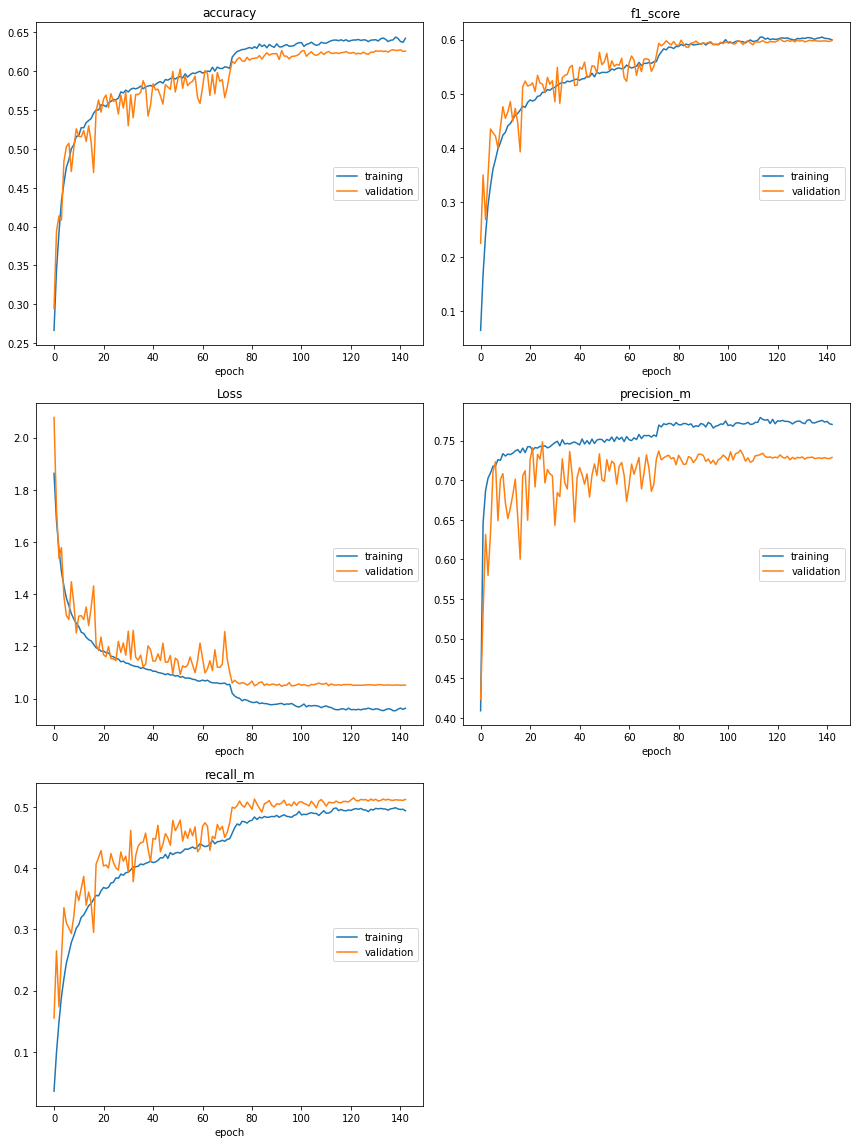

accuracy
	training         	 (min:    0.267, max:    0.644, cur:    0.642)
	validation       	 (min:    0.295, max:    0.627, cur:    0.626)
f1_score
	training         	 (min:    0.064, max:    0.605, cur:    0.599)
	validation       	 (min:    0.225, max:    0.601, cur:    0.598)
Loss
	training         	 (min:    0.954, max:    1.863, cur:    0.963)
	validation       	 (min:    1.047, max:    2.077, cur:    1.052)
precision_m
	training         	 (min:    0.409, max:    0.779, cur:    0.770)
	validation       	 (min:    0.423, max:    0.748, cur:    0.729)
recall_m
	training         	 (min:    0.036, max:    0.498, cur:    0.493)
	validation       	 (min:    0.155, max:    0.514, cur:    0.512)

Epoch 00143: val_loss did not improve from 1.04679


In [17]:
model.fit_generator(data_generator.flow(X_train, train_y,batch_size),
                        steps_per_epoch=len(X_train) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(X_test, test_y))

In [56]:
path = 'models/'
model_export = model.to_json()
with open(path +"Prelu.json", "w") as json_file:
    json_file.write(model_export)
model.save_weights(path +"Prelu.h5")

In [5]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image
from keras.models import load_model

#load model
model = model_from_json(open("models/prelu.json", "r").read())
# load weights
model2 = model.load_weights('models/prelu.h5')


In [6]:
model = create_model()
model.load_weights('models/prelu.h5')

In [7]:
evalutaion = model.evaluate(np.array(X_test), np.array(test_y))
print("" )
print("" )
print("**************Result**************" )
print("Loss: " + str(evalutaion[0]))
print("Accuracy: " + str(evalutaion[1]))
print("F1 Score: " + str(evalutaion[2]))
print("Precision: " + str(evalutaion[3]))
print("**********************************" )

113/113 [==============================] - 3s 21ms/step - loss: 1.0493 - accuracy: 0.6288 - f1_score: 0.6060 - precision_m: 0.7274 - recall_m: 0.5223 1s - loss: 1.0311 - accuracy: 0.6354 - f1_score:


**************Result**************
Loss: 1.0518296957015991
Accuracy: 0.6258010864257812
F1 Score: 0.5982038378715515
Precision: 0.7287073135375977
**********************************


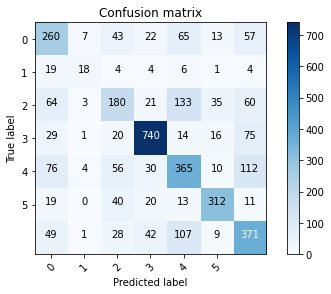

In [8]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(test_y,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
dp.plot_confusion_matrix(confusion_mtx, classes = range(6))